In [2]:
#FeatureSelectionByMultilevelEnrichmentImports
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

import fisher

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import loompy
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['Age_6_6w', 'Age_7_4w', 'Age_9_1w', 'Age_?', 'CPM_thres', 'Clusters', 'NCells', 'Outliers', 'Sex_', 'Tissue_Cerebellum', 'Tissue_H3K27M thalamic pediatric glioma', 'Tissue_Hindbrain', 'Tissue_Midbrain', 'Total']


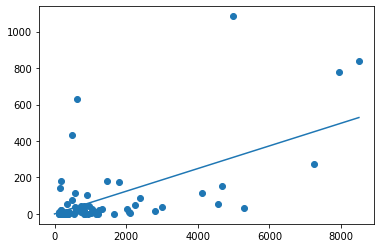

In [3]:
fdir = '/data/proj/scATAC/chromograph/build_20200513_glioma/All'

f_ds = os.path.join(fdir, 'All_peaks.loom')
f_agg = os.path.join(fdir, 'All_peaks.agg.loom')

with loompy.connect(f_ds) as ds:
    with loompy.connect(f_agg) as dsagg:
        print(dsagg.ca.keys())
        
        frac_glioma = np.sum(ds.ca.Tissue== 'H3K27M thalamic pediatric glioma') / ds.shape[1]
        plt.scatter(dsagg.ca.NCells, dsagg.ca['Tissue_H3K27M thalamic pediatric glioma'])
        x = np.linspace(0, np.max(dsagg.ca.NCells), np.max(dsagg.ca.NCells))
        plt.plot(x, frac_glioma * x, linestyle='solid')

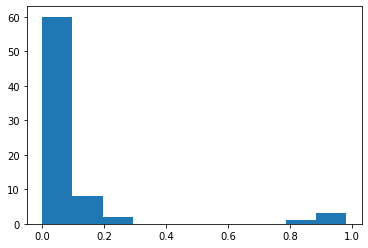

In [4]:
with loompy.connect(f_ds) as ds:
    with loompy.connect(f_agg) as dsagg:
        frac_glioma = dsagg.ca['Tissue_H3K27M thalamic pediatric glioma'] / dsagg.ca.NCells
        plt.hist(frac_glioma)

16:43:39 INFO     Found 11 clusters overrepresented with glioma cells
16:43:39 INFO     Identified 4 clusters with majority Glioma cells


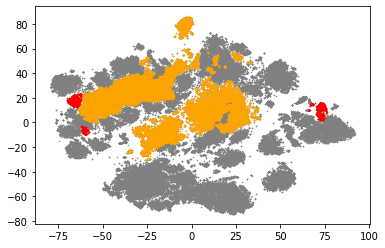

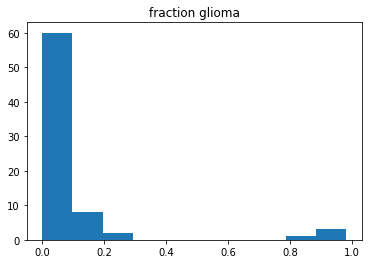

In [5]:
with loompy.connect(f_ds) as ds:
    with loompy.connect(f_agg) as dsagg:
        
        Total = ds.shape[1]
        Total_glioma = np.sum(ds.ca.Tissue == 'H3K27M thalamic pediatric glioma')
        fraction_glioma = dsagg.ca['Tissue_H3K27M thalamic pediatric glioma'] / dsagg.ca.NCells
        glioma_clusters = dsagg.ca.Clusters[fraction_glioma > 0.5]
        
        c = np.zeros((dsagg.shape[1], 4))
        c[:,0] = dsagg.ca['Tissue_H3K27M thalamic pediatric glioma']
        c[:,1] = dsagg.ca.NCells - c[:,0]
        c[:,2] = Total_glioma - c[:,0]
        c[:,3] = Total - dsagg.ca.NCells - c[:,2]
        c = c.astype(np.uint)

        _, p, _ = fisher.pvalue_npy(c[:, 0], c[:,1], c[:,2], c[:,3])
        odds = div0(c[:, 0] * c[:, 3], c[:, 1] * c[:, 2])

        sig = dsagg.ca.Clusters[p < 0.05]
        sig = [x for x in sig if x not in glioma_clusters]
        v = [x in sig for x in ds.ca.Clusters]
        g = [x in glioma_clusters for x in ds.ca.Clusters]
        
        logging.info(f'Found {len(sig)} clusters overrepresented with glioma cells')
        plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], marker = '.', c = 'gray', s=1)
        plt.scatter(ds.ca.TSNE[v,0], ds.ca.TSNE[v,1], marker = '.', c = 'orange', s=1)
        plt.scatter(ds.ca.TSNE[g,0], ds.ca.TSNE[g,1], marker = '.', c = 'red', s=1)

        
        plt.figure()
        plt.hist(fraction_glioma)
        plt.title(f'fraction glioma')
        logging.info(f'Identified {len(glioma_clusters)} clusters with majority Glioma cells')

In [31]:
import pybedtools
from pybedtools import BedTool
from chromograph.pipeline import config

config = config.load_config()

In [44]:
peaks_all = BedTool(os.path.join(fdir, 'peaks', 'Compounded_peaks.bed'))
print(len(peaks_all))

# ## Substract unwanted elements
enhancers = BedTool(os.path.join(config.paths.ref, 'regions', 'enhancer.bed'))
enhancers.count()
enhancers = peaks_all.intersect(enhancers, wa=True)
enhancer_IDs = [x[3] for x in enhancers]
print(enhancer_IDs[:10])

425261
['chr1:190810-191882', 'chr1:886065-886500', 'chr1:890747-891136', 'chr1:951230-951886', 'chr1:1026501-1027416', 'chr1:1088762-1089002', 'chr1:1109514-1109700', 'chr1:1150139-1150402', 'chr1:1185083-1185730', 'chr1:1185083-1185730']


In [ ]:
from tqdm import tqdm
f_out = os.path.join(fdir, 'Enhancers.loom')

with loompy.connect(f_ds) as ds:
    enh = set(enhancer_IDs)
    valid = np.array([x in enh for x in ds.ra.ID])
        
    progress = tqdm(ds.shape[1])
    with loompy.new(f_out) as dsout:  # Create a new, empty, loom file
        
        row_attrs = {k: ds.ra[k][valid] for k in ds.ra}
        for (ix, selection, view) in ds.scan(axis=1):
            layers = {k:view[k][valid,:] for k in view.layer}

            dsout.add_columns(layers, col_attrs=view.ca, row_attrs=row_attrs)
            progress.update(512)
    progress.close()

20480it [13:01, 40.26it/s]

In [ ]:
f_split = os.path.join(fdir, 'All_peaks_split_glioma.agg.loom')

agg_spec = {
    "Age": "tally",
    "Clusters": "first",
    "Class": "mode",
    "Total": "mean",
    "Sex": "tally",
    "Tissue": "tally",
    "SampleID": "tally",
    "TissuePool": "first",
    "Outliers": "mean",
    "PCW": "mean"
}

with loompy.connect(f_ds) as ds:
    cells = ds.col_attrs["Clusters"] >= 0
    tissue = ds.col_attrs['Tissue'] == 'H3K27M thalamic pediatric glioma'
    clusters = ds.col_attrs["Clusters"]
    labels = ['-'.join([x,y]) for x, y in zip(clusters.astype('str'), tissue.astype('str'))]
    n_labels = len(set(labels))
    Total = np.sum(cells)
    
    d = {k: v for v, k in enumerate(set(labels))}
    grouped = np.array([d[x] for x in labels])
  
    logging.info("Aggregating clusters")
    ds.aggregate(f_split, None, grouped, "sum", agg_spec)       

17:00:37 INFO     Aggregating clusters
